In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

### Uso de OpenCV

In [2]:
# Cargar dataset
DATASET_PATH = r"C:\Users\LENOVO\Documents\GitHub\dataset_planta"

train_dir = os.path.join(DATASET_PATH, "train")
test_dir = os.path.join(DATASET_PATH, "test")

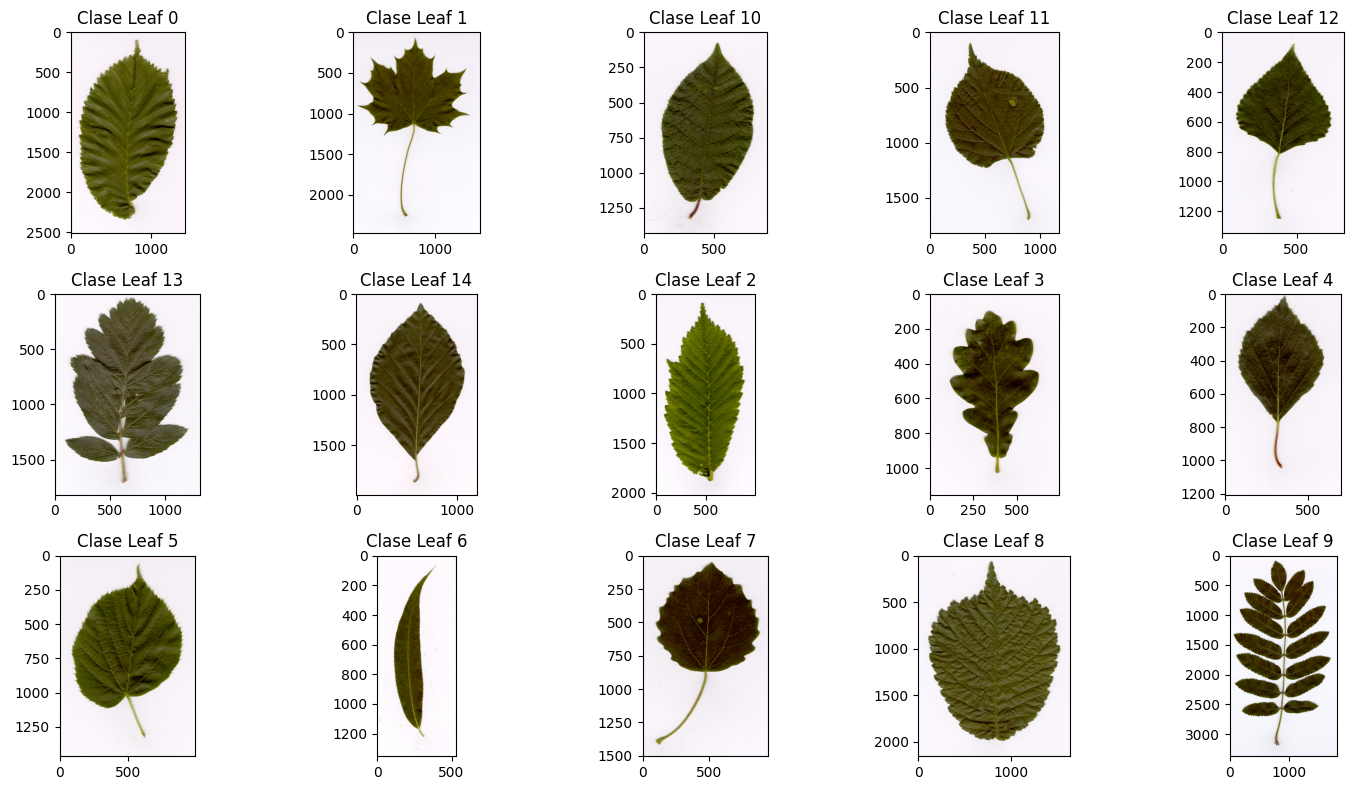

In [3]:
# Lista de carpetas (con las clases)
classes = sorted(os.listdir(train_dir)) #ordenar carpetas

# Mostrar una imagen por clase
plt.figure(figsize=(15, 8))

for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    img_name = os.listdir(cls_path)[0]  # tomamos la primera imagen por clase
    img_path = os.path.join(cls_path, img_name)
    
    # Cargar con OpenCV y convertir a RGB
    img = cv2.imread(img_path) #leer la imagen
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #oc lee en RGB
    
    # Mostrar
    plt.subplot(3, 5, i+1)  # 3 filas, 5 columnas (15 especies)
    plt.imshow(img)
    plt.title(f"Clase {cls}")

plt.tight_layout()
plt.show()

### Obtención de parámetros para entrenar un modelo

In [4]:
# Lista para guardar datos
data = []

for label, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        
        # Cargar imagen
        img = cv2.imread(img_path)
        if img is None:
            continue  # saltar archivos inválidos
        img = cv2.resize(img, (512, 512))  # redimensionar para consistencia
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Preprocesamiento - llevar a escala de grises
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) #Invertirmos B y N

        # quitar ruido pequeño antes de contorno
        kernel = np.ones((5,5), np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # Contornos
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0: #contorno límite no encontrado
            continue
        cnt = max(contours, key=cv2.contourArea)  #tomar el más grande
        
        # Features
        area = cv2.contourArea(cnt) #Escala del área por pixeles (muy grande)
        perimeter = cv2.arcLength(cnt, True)
        mask = thresh == 255
        mean_color = img_rgb[mask].mean(axis=0)
        
        # Guardar en lista
        data.append({
            "clase": label,
            "area": area,
            "perimetro": perimeter,
            "color_r": mean_color[0],
            "color_g": mean_color[1],
            "color_b": mean_color[2]
        })

# Convertir a DataFrame
df = pd.DataFrame(data)
print(df.head())
df.to_csv("../data/processed/features_hojas.csv", index=False)

   clase      area    perimetro    color_r    color_g    color_b
0      0  130421.5  1752.805252  82.761569  83.424297  16.204328
1      0  134377.0  1704.302726  86.901284  85.935026  31.468579
2      0  118506.5  1597.006261  87.487927  88.046194  25.395815
3      0  118406.0  1595.307777  85.966542  85.596302  25.370483
4      0  125658.0  1625.793060  93.087552  94.675049  24.651167


In [5]:
df.head()

,clase,area,perimetro,color_r,color_g,color_b
0,0,130421.5,1752.805252,82.761569,83.424297,16.204328
1,0,134377.0,1704.302726,86.901284,85.935026,31.468579
2,0,118506.5,1597.006261,87.487927,88.046194,25.395815
3,0,118406.0,1595.307777,85.966542,85.596302,25.370483
4,0,125658.0,1625.793060,93.087552,94.675049,24.651167


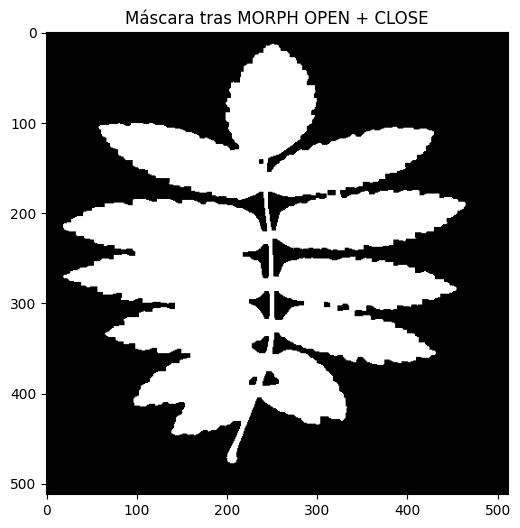

In [6]:
#CODIGO TEMPORAL. REVISION DE EXTRACCION DE VARIABLES 
plt.figure(figsize=(6,6))
plt.imshow(thresh, cmap="gray")
plt.title("Máscara tras MORPH OPEN + CLOSE")
plt.show()

In [7]:
df.shape

(1125, 6)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
clase,1125.0,7.000000,4.322415,0.000000,3.000000,7.000000,11.000000,14.000000
area,1125.0,92189.742667,20532.836027,44413.500000,77009.500000,93646.000000,107722.500000,147311.000000
perimetro,1125.0,1820.809032,950.371590,961.075241,1364.042841,1537.650925,1830.184974,6269.018788
color_r,1125.0,73.625524,9.067446,47.695895,67.357963,73.423454,80.105357,103.968141
color_g,1125.0,70.746633,11.597555,29.807575,62.634583,69.978488,78.823738,104.312151
color_b,1125.0,16.014370,11.385526,1.375786,7.433324,12.803344,22.350058,60.198958


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   clase      1125 non-null   int64  
 1   area       1125 non-null   float64
 2   perimetro  1125 non-null   float64
 3   color_r    1125 non-null   float64
 4   color_g    1125 non-null   float64
 5   color_b    1125 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 52.9 KB


### Partición y análisis con Modelos básicos

In [10]:
#Partición de datos
X = df.drop("clase", axis=1)
y = df["clase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Comentario: mantener proporciones de cada tipo de planta en la partición (stratify)

### Escalado de datos para modelos susceptibles (KNN y RandomForest)

In [11]:
#Escalado con StandardScaler para llevarlos a una media 0 y desviación estándar 1 (mas o menos misma escala)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Entrenamiento y Modelado - RandomForest

Empezaré entrenamiento con un RandomForest porque es más robusto con datasets con un número reducido de características. Además, al combinar múltiples árboles, permite capturar relaciones no lineales y diversas combinaciones de rasgos de las hojas que ayudan a mejorar el poder de clasificación frente a otros modelos un poco más simples.

In [12]:
#Entrenamiento e inicialización del modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42) #por default

#Cross-validation (evitar única partición)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Accuracy por fold:", cv_scores)
print("Accuracy promedio:", cv_scores.mean())
print("Desviación estándar:", cv_scores.std())

Accuracy por fold: [0.79444444 0.79444444 0.83333333 0.81111111 0.82222222]
Accuracy promedio: 0.8111111111111111
Desviación estándar: 0.015315609724544717


In [13]:
# Entrenar en todo el set de entrenamiento
clf.fit(X_train, y_train)

# Predecir en test
y_pred = clf.predict(X_test)

# Métricas finales
print("\nAccuracy en test:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy en test: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       1.00      0.93      0.97        15
           2       0.71      0.67      0.69        15
           3       0.92      0.73      0.81        15
           4       0.81      0.87      0.84        15
           5       0.88      1.00      0.94        15
           6       0.88      0.93      0.90        15
           7       0.72      0.87      0.79        15
           8       0.93      0.87      0.90        15
           9       0.82      0.93      0.88        15
          10       0.60      0.60      0.60        15
          11       0.88      0.93      0.90        15
          12       1.00      0.80      0.89        15
          13       0.71      0.67      0.69        15
          14       1.00      1.00      1.00        15

    accuracy                           0.84       225
   macro avg       0.84      0.

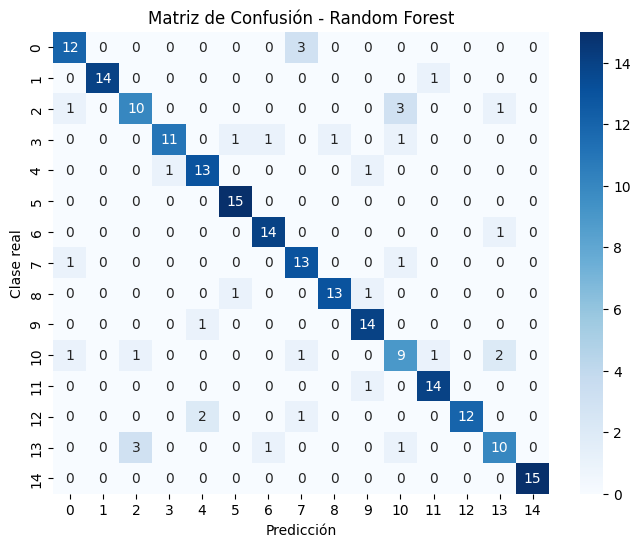

In [14]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

##### Comentario: interesante ver que la diagonal tiene muy bajos valores propios identificables del mismo grupo de plantas. No está identificando correctamente.

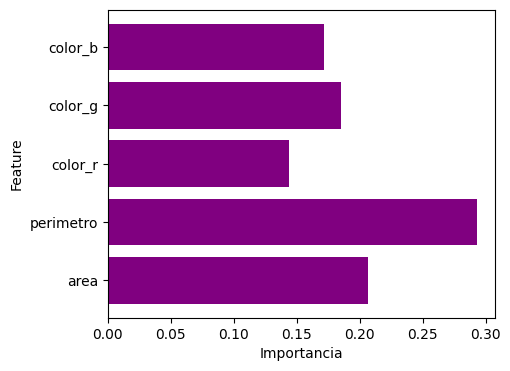

In [15]:
#Importancia de las caracteríticas para el modelo
importances = clf.feature_importances_
features = X.columns

plt.figure(figsize=(5,4))
plt.barh(features, importances, color='purple')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.show()

**Comentario**: Aparentemente, la característica de mayor importancia para la clasificación a partir de las hojas es el área y perímetro.

### **Comparación con KNN - method**

k=3: Accuracy promedio = 0.7567
k=5: Accuracy promedio = 0.7578
k=7: Accuracy promedio = 0.7622
k=9: Accuracy promedio = 0.7644
k=11: Accuracy promedio = 0.7667


Text(0.5, 1.0, 'Evaluación de KNN')

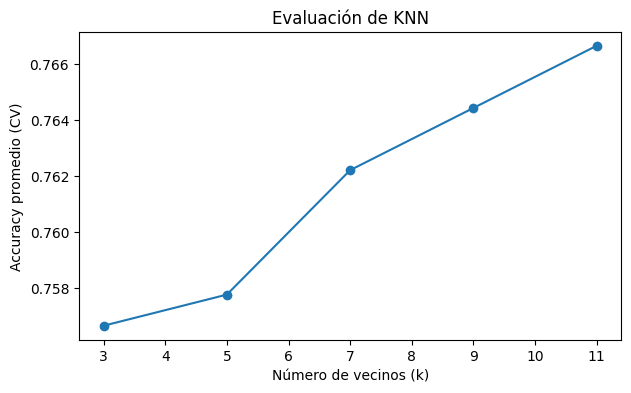

In [16]:
# Probamos varios valores de k
k_values = [3, 5, 7, 9, 11]
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    mean_scores.append(scores.mean())
    print(f"k={k}: Accuracy promedio = {scores.mean():.4f}")

# Graficar resultados
plt.figure(figsize=(7,4))
plt.plot(k_values, mean_scores, marker='o')
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Accuracy promedio (CV)")
plt.title("Evaluación de KNN")

#### **Elegir el mejor k para KNN**

In [17]:
# Elegir el mejor k
best_k = k_values[np.argmax(mean_scores)]
print(f"Mejor valor de k: {best_k}")

# Entrenar con el mejor k y evaluar en test
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
y_pred_knn = knn_best.predict(X_test_scaled)

print("\nAccuracy en test (KNN):", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

Mejor valor de k: 11

Accuracy en test (KNN): 0.7911111111111111

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       1.00      0.87      0.93        15
           2       0.78      0.47      0.58        15
           3       0.79      0.73      0.76        15
           4       0.73      0.73      0.73        15
           5       0.71      1.00      0.83        15
           6       0.70      0.93      0.80        15
           7       0.64      0.93      0.76        15
           8       0.86      0.80      0.83        15
           9       0.75      0.80      0.77        15
          10       0.92      0.73      0.81        15
          11       0.71      0.80      0.75        15
          12       1.00      0.73      0.85        15
          13       0.62      0.53      0.57        15
          14       1.00      1.00      1.00        15

    accuracy                           0.79 

##### *Comentario* : No existe mucha diferencia en los niveles de Accuracy entre RF y KNN, intentaremos optimizar los parámetros de RF. 

### Optimización de parámetros en RandomForest

In [18]:
#Uso de GridSearchCV para optimizar hiperparámetros en RandomForest

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,
                    cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

print("Mejores parámetros encontrados:")
print(grid.best_params_)

mejor_modelo = grid.best_estimator_
y_pred_opt = mejor_modelo.predict(X_test_scaled)

print("\nAccuracy optimizado:", accuracy_score(y_test, y_pred_opt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros encontrados:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Accuracy optimizado: 0.8355555555555556

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       1.00      0.93      0.97        15
           2       0.75      0.60      0.67        15
           3       0.92      0.73      0.81        15
           4       0.87      0.87      0.87        15
           5       0.88      1.00      0.94        15
           6       0.87      0.87      0.87        15
           7       0.70      0.93      0.80        15
           8       0.92      0.80      0.86        15
           9       0.78      0.93      0.85        15
          10       0.59      0.67      0.62        15
          11       0.82      0.93      0.88        15
          12       1.00      0.80      0.89     

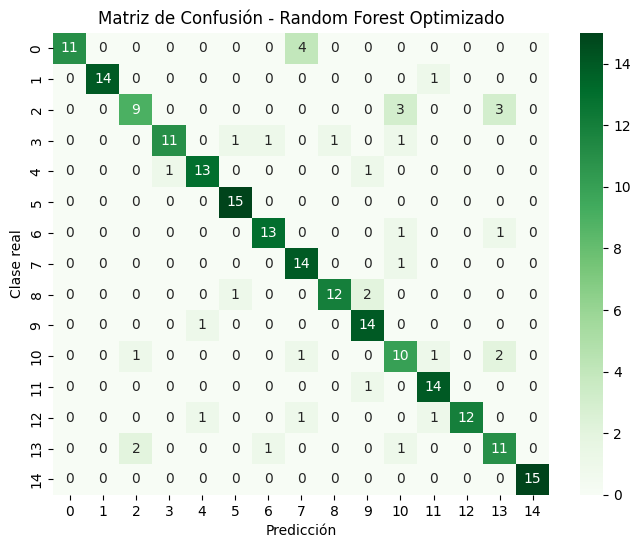

In [19]:
# Matriz de confusión del modelo optimizado
cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(8,6))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.show()

##### **Comentario**: Está más que claro que el modelo necesita más características para poder clasificar correctamente las hojas de cada especie. Éstas por si solas, no están clasificando bien las especies. 

### **Añadiremos más características**

Añadiremos nuevas variables geométricas y de textura para mejorar la capacidad del modelo para distinguir hojas similares.

In [20]:
def extract_extra_features_cv2(img):
    img = cv2.resize(img, (512,512))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Segmentación inversa
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remover ruido
    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)  
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    
    cnt = max(contours, key=cv2.contourArea)
    
    # Área y perímetro
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    
    # Bounding box
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h
    extent = float(area) / (w * h)
    
    # Convex hull
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area
    
    # Circularidad
    if perimeter == 0:
        circularity = 0
    else:
        circularity = (4 * np.pi * area) / (perimeter ** 2)
    
    # Hu moments (shape descriptors)
    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments).flatten()
    
    # --- Textura simple ---
    # Histograma
    hist = cv2.calcHist([gray],[0],None,[256],[0,256]).flatten()
    hist_norm = hist / hist.sum()
    
    # Entropía (textura)
    entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-7))
    
    # Contraste aproximado (varianza de intensidades)
    contrast = np.var(gray)

    # Homogeneidad aproximada (proxy)
    homogeneity = 1 / (1 + contrast)
    
    return {
        "aspect_ratio": aspect_ratio,
        "extent": extent,
        "solidity": solidity,
        "circularity": circularity,
        "hu1": hu[0],
        "hu2": hu[1],
        "hu3": hu[2],
        "hu4": hu[3],
        "hu5": hu[4],
        "hu6": hu[5],
        "hu7": hu[6],
        "entropy": entropy,
        "contrast": contrast,
        "homogeneity": homogeneity
    }

In [21]:
#Enlistado de nuevas características

extra_features_list = []

for label, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue
        
        feats = extract_extra_features_cv2(img)
        if feats is None:
            continue
        
        feats["clase"] = label
        feats["filename"] = img_name
        feats["class_name"] = cls
        extra_features_list.append(feats)

df_extra = pd.DataFrame(extra_features_list)
print("Nuevas características extraídas:")
display(df_extra.head())

Nuevas características extraídas:


,aspect_ratio,extent,solidity,circularity,hu1,hu2,hu3,hu4,hu5,hu6,hu7,entropy,contrast,homogeneity,clase,filename,class_name
0,0.967105,0.648553,0.929806,0.533448,0.164765,0.001321,0.000052,8.642517e-07,-1.583258e-12,-7.090766e-09,-5.544658e-12,6.199513,7393.550328,0.000135,0,1000.jpg,Leaf 0
1,1.008753,0.637834,0.944604,0.581355,0.163080,0.000716,0.000044,7.015285e-07,3.247267e-12,1.668798e-08,-2.147384e-12,6.123281,7142.802887,0.000140,0,1001.jpg,Leaf 0
2,0.900881,0.638209,0.947446,0.583900,0.163392,0.000797,0.000049,6.072195e-07,-3.190499e-12,-1.635320e-08,9.175254e-13,5.997852,6914.163092,0.000145,0,1002.jpg,Leaf 0
3,0.943052,0.651492,0.938862,0.584648,0.164316,0.000962,0.000054,1.315747e-06,-9.622212e-12,-3.196264e-08,-5.533683e-12,5.842319,7341.048090,0.000136,0,1003.jpg,Leaf 0
4,1.013986,0.673354,0.945316,0.597406,0.161285,0.000355,0.000003,1.003076e-07,-1.157034e-14,-8.524129e-10,5.317624e-14,5.871409,6730.693455,0.000149,0,1004.jpg,Leaf 0


In [22]:
#Guardar el nuevo DataFrame con características adicionales
df_extra.to_csv("../data/processed/new_features_hojas.csv", index=False)

In [23]:
# Reiniciar índices para asegurar alineación (las plantas no tienen ID, hacemos concat asumiendo mismo orden de iteración)
df = df.reset_index(drop=True)
df_extra = df_extra.reset_index(drop=True)

df_total = pd.concat([df, df_extra.drop(columns=["clase", "filename", "class_name"])], axis=1)

df_total.head()

,clase,area,perimetro,color_r,color_g,color_b,aspect_ratio,extent,solidity,circularity,hu1,hu2,hu3,hu4,hu5,hu6,hu7,entropy,contrast,homogeneity
0,0,130421.5,1752.805252,82.761569,83.424297,16.204328,0.967105,0.648553,0.929806,0.533448,0.164765,0.001321,0.000052,8.642517e-07,-1.583258e-12,-7.090766e-09,-5.544658e-12,6.199513,7393.550328,0.000135
1,0,134377.0,1704.302726,86.901284,85.935026,31.468579,1.008753,0.637834,0.944604,0.581355,0.163080,0.000716,0.000044,7.015285e-07,3.247267e-12,1.668798e-08,-2.147384e-12,6.123281,7142.802887,0.000140
2,0,118506.5,1597.006261,87.487927,88.046194,25.395815,0.900881,0.638209,0.947446,0.583900,0.163392,0.000797,0.000049,6.072195e-07,-3.190499e-12,-1.635320e-08,9.175254e-13,5.997852,6914.163092,0.000145
3,0,118406.0,1595.307777,85.966542,85.596302,25.370483,0.943052,0.651492,0.938862,0.584648,0.164316,0.000962,0.000054,1.315747e-06,-9.622212e-12,-3.196264e-08,-5.533683e-12,5.842319,7341.048090,0.000136
4,0,125658.0,1625.793060,93.087552,94.675049,24.651167,1.013986,0.673354,0.945316,0.597406,0.161285,0.000355,0.000003,1.003076e-07,-1.157034e-14,-8.524129e-10,5.317624e-14,5.871409,6730.693455,0.000149


In [24]:
#Guardar el nuevo DataFrame total
df_total.to_csv("../data/processed/total_features_hojas.csv", index=False)

In [25]:
df_total.head()

,clase,area,perimetro,color_r,color_g,color_b,aspect_ratio,extent,solidity,circularity,hu1,hu2,hu3,hu4,hu5,hu6,hu7,entropy,contrast,homogeneity
0,0,130421.5,1752.805252,82.761569,83.424297,16.204328,0.967105,0.648553,0.929806,0.533448,0.164765,0.001321,0.000052,8.642517e-07,-1.583258e-12,-7.090766e-09,-5.544658e-12,6.199513,7393.550328,0.000135
1,0,134377.0,1704.302726,86.901284,85.935026,31.468579,1.008753,0.637834,0.944604,0.581355,0.163080,0.000716,0.000044,7.015285e-07,3.247267e-12,1.668798e-08,-2.147384e-12,6.123281,7142.802887,0.000140
2,0,118506.5,1597.006261,87.487927,88.046194,25.395815,0.900881,0.638209,0.947446,0.583900,0.163392,0.000797,0.000049,6.072195e-07,-3.190499e-12,-1.635320e-08,9.175254e-13,5.997852,6914.163092,0.000145
3,0,118406.0,1595.307777,85.966542,85.596302,25.370483,0.943052,0.651492,0.938862,0.584648,0.164316,0.000962,0.000054,1.315747e-06,-9.622212e-12,-3.196264e-08,-5.533683e-12,5.842319,7341.048090,0.000136
4,0,125658.0,1625.793060,93.087552,94.675049,24.651167,1.013986,0.673354,0.945316,0.597406,0.161285,0.000355,0.000003,1.003076e-07,-1.157034e-14,-8.524129e-10,5.317624e-14,5.871409,6730.693455,0.000149


In [26]:
#valuar valores nulos en el DataFrame total
df_total.isna().sum()

clase           0
area            0
perimetro       0
color_r         0
color_g         0
color_b         0
aspect_ratio    0
extent          0
solidity        0
circularity     0
hu1             0
hu2             0
hu3             0
hu4             0
hu5             0
hu6             0
hu7             0
entropy         0
contrast        0
homogeneity     0
dtype: int64

In [27]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   clase         1125 non-null   int64  
 1   area          1125 non-null   float64
 2   perimetro     1125 non-null   float64
 3   color_r       1125 non-null   float64
 4   color_g       1125 non-null   float64
 5   color_b       1125 non-null   float64
 6   aspect_ratio  1125 non-null   float64
 7   extent        1125 non-null   float64
 8   solidity      1125 non-null   float64
 9   circularity   1125 non-null   float64
 10  hu1           1125 non-null   float64
 11  hu2           1125 non-null   float64
 12  hu3           1125 non-null   float64
 13  hu4           1125 non-null   float64
 14  hu5           1125 non-null   float64
 15  hu6           1125 non-null   float64
 16  hu7           1125 non-null   float64
 17  entropy       1125 non-null   float32
 18  contrast      1125 non-null 

In [28]:
df_total.describe().T

,count,mean,std,min,25%,50%,75%,max
clase,1125.0,7.000000e+00,4.322415e+00,0.000000e+00,3.000000e+00,7.000000e+00,1.100000e+01,14.000000
area,1125.0,9.218974e+04,2.053284e+04,4.441350e+04,7.700950e+04,9.364600e+04,1.077225e+05,147311.000000
perimetro,1125.0,1.820809e+03,9.503716e+02,9.610752e+02,1.364043e+03,1.537651e+03,1.830185e+03,6269.018788
color_r,1125.0,7.362552e+01,9.067446e+00,4.769589e+01,6.735796e+01,7.342345e+01,8.010536e+01,103.968141
color_g,1125.0,7.074663e+01,1.159756e+01,2.980758e+01,6.263458e+01,6.997849e+01,7.882374e+01,104.312151
color_b,1125.0,1.601437e+01,1.138553e+01,1.375786e+00,7.433324e+00,1.280334e+01,2.235006e+01,60.198958
aspect_ratio,1125.0,1.000355e+00,2.095722e-01,5.208845e-01,8.971963e-01,9.514349e-01,1.040404e+00,1.921488
extent,1125.0,5.638573e-01,9.735235e-02,2.540682e-01,5.106392e-01,5.863156e-01,6.375122e-01,0.759356
solidity,1125.0,8.505463e-01,1.326774e-01,4.271482e-01,8.087230e-01,9.116563e-01,9.394352e-01,0.988941
circularity,1125.0,4.771953e-01,1.957349e-01,2.275525e-02,3.365632e-01,5.572808e-01,6.186777e-01,0.835929


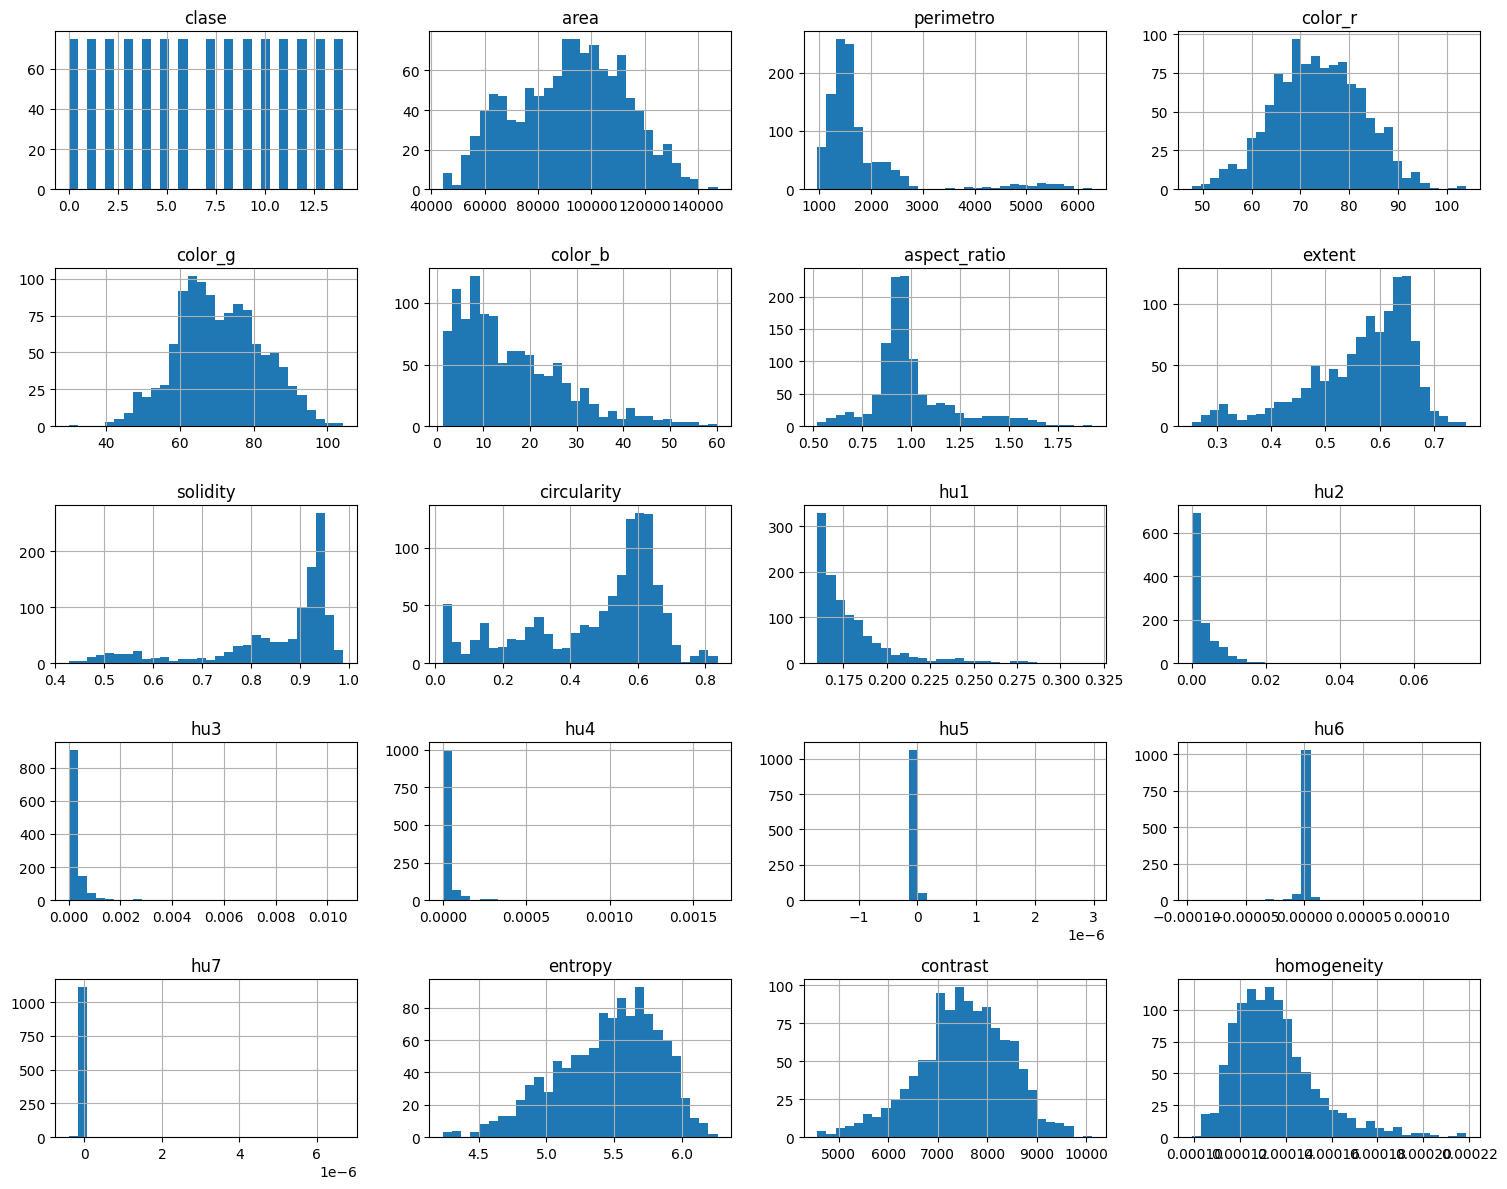

In [29]:
df_total.hist(figsize=(15, 12), bins=30)
plt.tight_layout()
plt.show()